# Urban Area Detection Using Landsat Images

I have done this project as a part of my course work for "Python Foundation for Spatial Analysis" conducted by Spatial Thoughts organization. The study area selected is Houstan city in Texas, USA. 


For this study the data used is Landsat 8-9 OLI/TIRS Collection 2 Level 2.
The Landsat image has the date of occurance as 26 August 2017, which is taken as 20170524 . To identify the urban area different indexes are used. In this case the index used are NDBI and NDVI.



In [1]:
# import all the necessary modules

import os
import array as ar
import rasterio
import numpy as np
from numpy import int64
%matplotlib inline
import xarray as xr
import rioxarray as rxr
from glob import glob
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from rioxarray.merge import merge_arrays
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

The Landsat data to be used is opened from it's path. The data used contains two scenes to complete the area. Different scenes are defined based on their path and row, In this case;
- Path: 025 • Row: 039
- Path: 025 • Row: 040

In [ ]:
# define input path for bands

data_path = "urban"

band4 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B4.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B4.TIF"]                
band5 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B5.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B5.TIF"]
band6 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B6.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B6.TIF"]

The merge function is defined to merge the different scenes.

In [ ]:
def merge(fp):
    datasets = []
    for tile in fp:
        file = os.path.join(data_path, tile)
        datasets.append(rxr.open_rasterio(file, mask_and_scale=True))
    return merge_arrays(datasets)


The different bands containing different scenes are merged into one image. Merged bands are plotted.

In [ ]:
merged_band4 = merge(band4)
merged_band4
merged_band5 = merge(band5)
merged_band5
merged_band6 = merge(band6)
merged_band6

In [ ]:
f, ax = plt.subplots(figsize = (15,10))

ep.plot_bands(merged_band4, cmap="rainbow", title="Band 4 Merged", ax=ax)

ax.set_axis_off()
plt.show()

The merged bands are saved and opened to stack the data one over the other.

In [2]:
merged_band4.rio.to_raster(os.path.join("urban", "outputs", "band4.tif"), compress="LZW")

merged_band5.rio.to_raster(os.path.join("urban", "outputs", "band5.tif"), compress="LZW")

merged_band6.rio.to_raster(os.path.join("urban", "outputs", "band6.tif"), compress="LZW")


NameError: name 'merged_band4' is not defined

The glob function is used to group the similar bands together. 
This is done to stack the data together, which is needed for the index calculation. The extent of study area is read using a shapefiile.

In [3]:
shp_path = os.path.join("urban", "aoi_n.shp")
aoi = gpd.read_file(shp_path)

before =  "*band[4-6]*.TIF"

path = os.path.join( "urban", "outputs", before)
band_path = glob(path)
print(band_path)

['urban\\outputs\\band4.tif', 'urban\\outputs\\band5.tif', 'urban\\outputs\\band6.tif']


In [4]:
aoi = gpd.read_file(shp_path)

To cut the Landsat data up to the extent of the Area of Interest, the projection of both data is checked. And the area of interst is projected to the coordinate system of the Landsat data.

In [5]:
for data in band_path:
    landsat_crs = es.crs_check(data)
    aoi_utm = aoi.to_crs(landsat_crs)

Two functions are defined to read the different bands of data. Both of them are clubbed together one through the other.

- The open_clean_band function is used clip the given bands to the area of interest.

- The process_bands function is defined to stack all the clipped bands together one over the other.

In [6]:
# stacking and cropping the band

def open_clean_band(band_path, crop_layer=None):
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()

    return cleaned_band

def process_bands(paths, crop_layer=None, stack=False):
    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands


The Landsat data is stacked using the predefined functions. The stack contains.
- band_clip[0] = Band 4
- band_clip[1] = band 5
- band_clip[2] = Band 6 

In [ ]:
band_clip = process_bands(band_path, crop_layer=aoi_utm, stack=True)

In [ ]:
ep.plot_rgb(band_clip.values,
            rgb=[2, 1, 0],
            title="Some Composite Landsat Data")
plt.show()

The clipped merged landsat data is plotted.

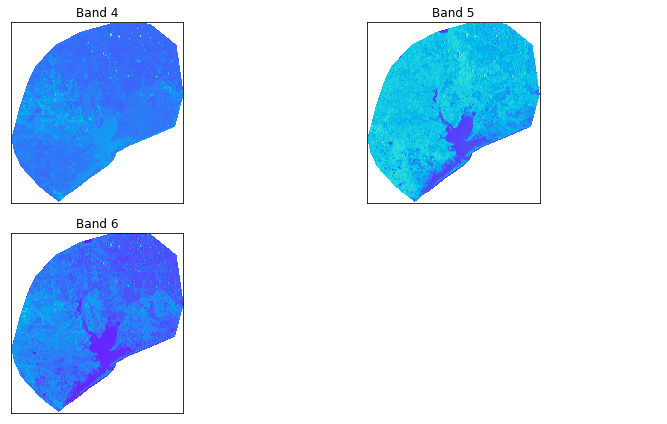

In [15]:
band_titles = ["Band 4",
               "Band 5",
               "Band 6"]
ep.plot_bands(band_clip, figsize = (11,6), cols=2, cmap="rainbow", title=band_titles, cbar=False)
plt.show()

### Normal Difference Built-up Index(NDBI)

NDBI = (SWIR – NIR) / (SWIR + NIR)

For Landsat 8 data, NDBI = (Band 6 – Band 5) / (Band 6 + Band 5)


In [16]:
ndbi = es.normalized_diff( band_clip[2], band_clip[1])

 # (band_clip[2] - band_clip[1]) / (band_clip[2] + band_clip[1])

NameError: name 'ndbi' is not defined

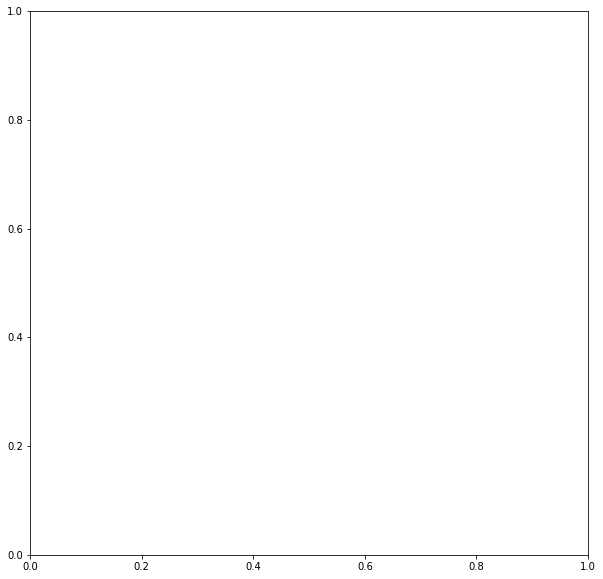

In [2]:
fig, ax = plt.subplots(figsize=(10, 10))

post_ndbi = ax.imshow(ndbi,
                      cmap='Reds',vmin=-0.3,
                      vmax=0.2,
)

plt.show()


### Normalized Difference Vegetation Index (NDVI)

NDVI = (NIR – Red) / (NIR + Red)

For Landsat 8 data, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4)

In order to facilitate the subsequent processing, the derived NDVI image was recoded with 254 for all pixels having positive indices (vegetation) and 0 for all remaining pixels of negative indices.

In [17]:
ndvi = es.normalized_diff( band_clip[1], band_clip[0])
# (band_clip[1]-band_clip[0])/(band_clip[1]+band_clip[0])


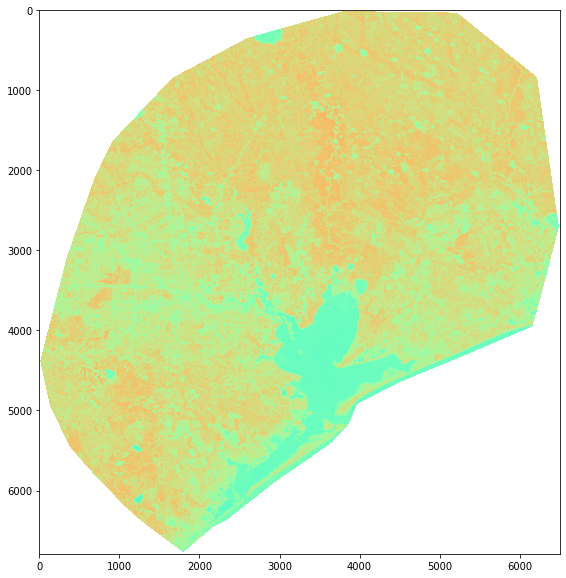

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

post_ndvi = ax.imshow(ndvi,
                      cmap='rainbow',vmin=-1,
                      vmax=1,
)

plt.show()

### Built-up Index (BU)

There are lots of indexes for the analysis of built-up area.

The build-up areas and bare soil reflects more SWIR than NIR. Water body doesn’t reflect on Infrared spectrum.

Build-up Index is the index for analysis of urban pattern using NDBI and NDVI. Built-up index is the binary image with only higher positive value indicates built-up and barren thus, allows BU to map the built-up area automatically.

BU = NDBI - NDVI



In [18]:
bu = ndbi- ndvi

Built up index is reclassified using histogram to select urban area.

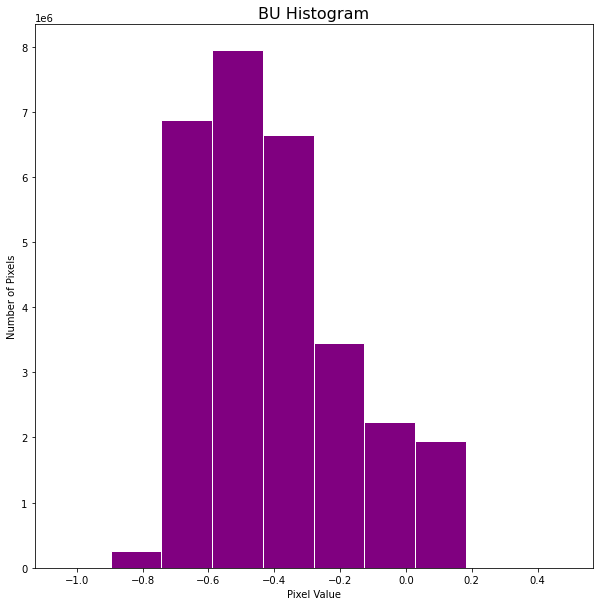

In [19]:
# Plot a histogram of the BU difference image

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(bu.ravel(),
        color='purple',
        edgecolor='white')
ax.set_title("BU Histogram",
             fontsize=16)
ax.set(xlabel="Pixel Value",
       ylabel="Number of Pixels")

plt.show()


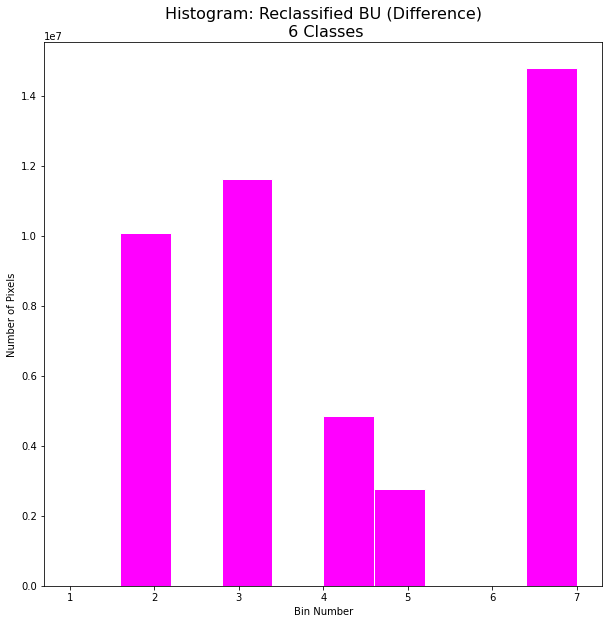

In [20]:
counts, bins, patches = ax.hist(bu.ravel(),
                                color='springgreen',
                                bins=6
                               )
class_bins = bins

ndbi_class = np.digitize(bu, class_bins)
np.unique(ndbi_class)

#bins

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(ndbi_class.ravel(),
        color='magenta',
        edgecolor='white')
ax.set_title("Histogram: Reclassified BU (Difference)\n 6 Classes",
             fontsize=16)
ax.set(xlabel="Bin Number",
       ylabel="Number of Pixels")
plt.show()

In [21]:
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['orange','yellow','green','black','blue','blue','white']

cmap = ListedColormap(colors)

ax.imshow(ndbi_class,cmap=cmap)

ax.set_title("Reclassified BU (Difference)\n 6 Classes ")
ax.set_axis_off

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.savefig('bu.tif')

plt.show()

MemoryError: Unable to allocate 168. MiB for an array with shape (6791, 6499) and data type float32

<Figure size 720x720 with 1 Axes>

Reference 

Use of normalized difference built-up index in automatically mapping urban areas from TM imagery

https://www.tandfonline.com/doi/abs/10.1080/01431160304987